In [ ]:
! pip install langchain-openai langchain-anthropic langgraph 

# Workflows and Agents

Anthropic released an excellent [blog post](https://www.anthropic.com/research/building-effective-agents) on building effective agents. 

> "Agent" can be defined in several ways. Some customers define agents as fully autonomous systems that operate independently over extended periods, using various tools to accomplish complex tasks. Others use the term to describe more prescriptive implementations that follow predefined workflows. At Anthropic, we categorize all these variations as agentic systems

It offered a definition of the difference between workflows and agents: 

> Workflows are systems where LLMs and tools are orchestrated through predefined code paths.
> Agents, on the other hand, are systems where LLMs dynamically direct their own processes and tool usage, maintaining control over how they accomplish tasks.

Below, we'll show how to build workflows and agents using LangGraph.

## Why use a framework?

First, it is important to note that the blog post correctly points out that frameworks can add abstraction and complexity: 

> (Frameworks) often create extra layers of abstraction that can obscure the underlying prompts ​​and responses, making them harder to debug.

LangGraph is designed to be low-level, without any prompt or architecture abstraction. 

The post makes an important point about agents, which also extends to workflows: 

> Agents can then *pause for human feedback at checkpoints* or when encountering blockers.

We have found that this is central to building effective agents in practice. 

While it's true that workflow and agent implementations can be achieves without a framework, sometimes in a few lines of code, LangGraph is designed with a [persistence layer](https://langchain-ai.github.io/langgraph/concepts/persistence/) that underpins the workflow or agent: 

* This enables short-term and long-term [memory](https://langchain-ai.github.io/langgraph/concepts/memory/). 
* This enables [interruption and resuming](https://langchain-ai.github.io/langgraph/concepts/breakpoints/) workflows or agents.
* This enables [human-in-the-loop](https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/) (e.g., to approve an agent's actions).
* This enables [shared-state for multi-agent](https://langchain-ai.github.io/langgraph/concepts/multi_agent/) systems.

## Building Blocks: The Augmented LLM 

LLM have [augmentations](https://www.anthropic.com/research/building-effective-agents) that support building workflows and agents. 

These include `structured outputs` and `tool calling`. 

LangGraph uses these augmentations to build workflows and agents.

In [44]:
# LLM
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")

from langchain_anthropic import ChatAnthropic
llm = ChatAnthropic(model="claude-3-5-sonnet-latest")


In [45]:
from pydantic import BaseModel, Field

# Structured output
class SearchQuery(BaseModel):
    search_query: str = Field(
        None, description="Query that is optimized web search."
    )
    justification: str = Field(
        None, justification="Why this query is relevant to the user's request."
    )

# Augment the LLM
structured_llm = llm.with_structured_output(SearchQuery)

# Invoke the LLM
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")
print(output.search_query)
print(output.justification)

relationship between calcium CT score and high cholesterol correlation atherosclerosis
This search query will help find scientific information about how coronary calcium scores are related to cholesterol levels and cardiovascular risk, as both are important markers for atherosclerosis.


In [12]:
def multiply(a: int, b: int) -> int:
    return a * b

# Augment the LLM
llm_with_tools = llm.bind_tools([multiply])

# Invoke the LLM
msg = llm_with_tools.invoke("What is 2 times 3?")

# Get the tool calls
msg.tool_calls


[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_IyRywjX46Ks1JAVuYghRP1jh',
  'type': 'tool_call'}]

## Chain

Each LLM call processes the output of the previous one. As noted in the [Anthropic blog post](https://www.anthropic.com/research/building-effective-agents): 

> Prompt chaining decomposes a task into a sequence of steps, where each LLM call processes the output of the previous one. You can add programmatic checks (see "gate” in the diagram below) on any intermediate steps to ensure that the process is still on track.

> When to use this workflow: This workflow is ideal for situations where the task can be easily and cleanly decomposed into fixed subtasks. The main goal is to trade off latency for higher accuracy, by making each LLM call an easier task.

#### Resources

**LangChain Academy**
 
See our lesson on chains here: 

https://github.com/langchain-ai/langchain-academy/blob/main/module-1/chain.ipynb


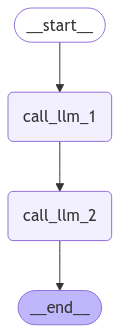

In [16]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# LLM
llm = ChatOpenAI(model="gpt-4o")

# State 
class State(TypedDict):
    topic: str
    joke: str
    story: str

def call_llm_1(state: State):
    msg=llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}

def call_llm_2(state: State):
    msg=llm.invoke(f"Write a story about {state['joke']}")
    return {"story": msg.content}

# Add the nodes
chain_builder = StateGraph(State)
chain_builder.add_node("call_llm_1", call_llm_1)
chain_builder.add_node("call_llm_2", call_llm_2)

# Build the chain
chain_builder.add_edge(START, "call_llm_1")
chain_builder.add_edge("call_llm_1", "call_llm_2")
chain_builder.add_edge("call_llm_2", END)
chain = chain_builder.compile()

# Show the chain 
display(Image(chain.get_graph().draw_mermaid_png()))

In [18]:
state = chain.invoke({"topic": "cats"})
print(state['story'])

In the quaint little town of Whiskerton, there was a not-so-ordinary cat named Whiskers. Whiskers was a tabby with striking emerald eyes and a penchant for curiosity that surpassed even the most inquisitive felines. Belonging to an avid tech enthusiast named Amelia, Whiskers spent most of his days lounging about the house, soaking in the sun, and observing Amelia as she tapped away at her computer.

One chilly autumn afternoon, Amelia was working intently on a project. Her fingers danced across the keyboard, the soft clicking sound echoed in the cozy living room. Whiskers stretched lazily on the sofa, half-heartedly swatting at a dangling string. As Amelia’s work intensified, the little gadget on her desk—the wireless mouse—caught Whiskers' attention. It skittered around the desk with each of Amelia's movements, seemingly as alive as any critter he had chased in the garden.

Intrigued, Whiskers padded over to the desk, his eyes locked onto the elusive mouse. Perplexed by its refusal to

Trace: 

https://smith.langchain.com/public/0d7efe23-7b9f-4e33-8e39-8f4fc5cf581e/r

## Parallelization 

LLMs can work simultaneously on a task. As noted in the [Anthropic blog post](https://www.anthropic.com/research/building-effective-agents): 

>LLMs can sometimes work simultaneously on a task and have their outputs aggregated programmatically. This workflow, parallelization, manifests in two key variations: Sectioning: Breaking a task into independent subtasks run in parallel. Voting: Running the same task multiple times to get diverse outputs.

> When to use this workflow: Parallelization is effective when the divided subtasks can be parallelized for speed, or when multiple perspectives or attempts are needed for higher confidence results. For complex tasks with multiple considerations, LLMs generally perform better when each consideration is handled by a separate LLM call, allowing focused attention on each specific aspect.

#### Resources

**Documentation**

See our documentation on parallelization here:

https://langchain-ai.github.io/langgraph/how-tos/branching/

**LangChain Academy**
 
See our lesson on parallelization here: 

https://github.com/langchain-ai/langchain-academy/blob/main/module-1/simple-graph.ipynb

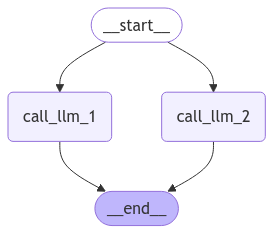

In [21]:
def call_llm_1(state: State):
    msg=llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}

def call_llm_2(state: State):
    msg=llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}

# Add the nodes
parallel_builder = StateGraph(State)
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)

# Build the chain
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge("call_llm_1", END)
parallel_builder.add_edge("call_llm_2", END)
parallel_workflow = parallel_builder.compile()

# Show the chain 
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

In [23]:
state = parallel_workflow.invoke({"topic": "cats"})
print(state['story'])
print("--- --- ---")
print("--- --- ---")
print(state['joke'])

Once upon a time in the quaint village of Whiskerfield, nestled between the gentle hills and sprawling fields of lavender, there existed a peculiar community known as Feline Fellowship. This village was home to an extraordinary population of cats, known far and wide for their unique talents and closely-knit society.

The leader of this feline fraternity was an elegant Maine Coon named Sir Whiskers. With a bushy tail like a plume of smoke and eyes as green as spring leaves, Sir Whiskers was both wise and gentle. He lived atop the tallest oak in the heart of Whiskerfield, where he could see over the entire village and into the distant horizon.

Each cat in Whiskerfield had a special role. There was Mistral, a swift Burmese who danced across the rooftops, delivering messages and keeping the village updated on the latest happenings. Her agility was unmatched, making her the fastest in all of Whiskerfield. Then there was Leo, the stout tabby who ran the local bakery. His paws deftly kneaded

Trace: 

https://smith.langchain.com/public/0d7efe23-7b9f-4e33-8e39-8f4fc5cf581e/r

## Routing 

Routing classifies an input and directs it to a specialized followup task. As noted in the [Anthropic blog post](https://www.anthropic.com/research/building-effective-agents): 

> Routing classifies an input and directs it to a specialized followup task. This workflow allows for separation of concerns, and building more specialized prompts. Without this workflow, optimizing for one kind of input can hurt performance on other inputs.

> When to use this workflow: Routing works well for complex tasks where there are distinct categories that are better handled separately, and where classification can be handled accurately, either by an LLM or a more traditional classification model/algorithm.

#### Resources

**LangChain Academy**

See our lesson on routing here: 

https://github.com/langchain-ai/langchain-academy/blob/main/module-1/router.ipynb

**Examples**

Here is a project on RAG that utilizes routing to route questions to a vectorstore or web search: 

https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_adaptive_rag_local/ 

See our video on on this here:

https://www.youtube.com/watch?v=bq1Plo2RhYI

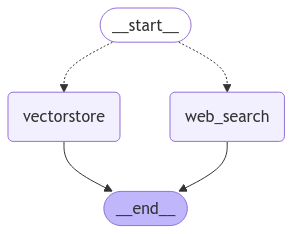

In [24]:
from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage

class Route(BaseModel):
    step: Literal["vectorstore", "web_search"] = Field(
        None, description="The next step in the routing process"
    )

# Augment the LLM
router = llm.with_structured_output(Route)

# State 
class State(TypedDict):
    question: str
    search_results: str

def web_search(state: State):
    print("Run web search with state['question']!")
    return {"search_results": "foo"}

def vectorstore(state: State):
    print("Run vectorstore with state['question']!")
    return {"search_results": "bar"}

def route_question(state: State):
    # Run the LLM with structured output
    decision = router.invoke([SystemMessage(content="Route current events to web_search and question about LangGraph to vectorstore."), 
                              HumanMessage(content=state["question"])])
    # Return the node name you want to visit next
    if decision.step == "vectorstore":
        return "vectorstore" 
    elif decision.step == "web_search":
        return "web_search"

# Add the nodes
router_builder = StateGraph(State)
router_builder.add_node("web_search", web_search)
router_builder.add_node("vectorstore", vectorstore)

# Set the conditional entry point
router_builder.set_conditional_entry_point(
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "vectorstore",
    },
)
router_builder.add_edge("web_search", END)
router_builder.add_edge("vectorstore", END)
router_workflow = router_builder.compile()

# Show the chain 
display(Image(router_workflow.get_graph().draw_mermaid_png()))

In [25]:
state = router_workflow.invoke({"question": "Did the Ram or Vikings win last night?"})
print(state['search_results'])

Run web search!
foo


Trace: 

https://smith.langchain.com/public/76cb966d-8a58-439d-9c8d-3766e8cbeb15/r

## Orchestrator-Worker 

A central LLM dynamically breaks down task, delegates them to worker LLMs, and synthesizes their results. As noted in the [Anthropic blog post](https://www.anthropic.com/research/building-effective-agents): 

> In the orchestrator-workers workflow, a central LLM dynamically breaks down tasks, delegates them to worker LLMs, and synthesizes their results.

> When to use this workflow: This workflow is well-suited for complex tasks where you can’t predict the subtasks needed (in coding, for example, the number of files that need to be changed and the nature of the change in each file likely depend on the task). Whereas it’s topographically similar, the key difference from parallelization is its flexibility—subtasks aren't pre-defined, but determined by the orchestrator based on the specific input.

#### Resources

**LangChain Academy**

See our lesson on orchestrator-worker here: 

https://github.com/langchain-ai/langchain-academy/blob/main/module-4/map-reduce.ipynb

--- 

**Examples**

Here is a project that uses orchestrator-worker for report planning and writing:

https://github.com/langchain-ai/report-mAIstro

See our video on on this here:

https://www.youtube.com/watch?v=wSxZ7yFbbas


In [27]:
from typing import Annotated,List
import operator

class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )

class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )

# Augment the LLM
planner = llm.with_structured_output(Sections)

class State(TypedDict):
    topic: str # Report topic
    sections: list[Section] # List of report sections 
    completed_sections: Annotated[list, operator.add] # All workers write to this key in parallel
    final_report: str # Final report

class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add] 

In [29]:
from langgraph.constants import Send

def generate_plan(state: State):

    # Generate queries  
    report_sections = planner.invoke([SystemMessage(content="Generate a plan for the report."),
                                      HumanMessage(content=f"Here is the report topic: {state['topic']}")])

    return {"sections": report_sections.sections}

def initiate_section_writing(state: State):
    """ This is the "map" step when we kick off web research for some sections of the report """    
    
    # Kick off section writing in parallel via Send() API for any sections that require research
    return [Send("write_section", {"section": s}) for s in state["sections"] ]

def write_section(state: WorkerState):

    # Generate section  
    section = llm.invoke([SystemMessage(content="Write a report section."),
                          HumanMessage(content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}")])
    
    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}

def finalize_report(state: State):
    """ Gather completed sections from research """    

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}

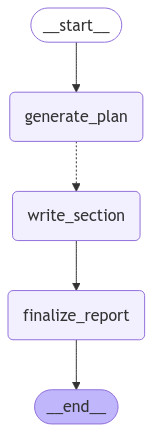

In [30]:
# Add the nodes
orchestrator_worker_builder = StateGraph(State)
orchestrator_worker_builder.add_node("generate_plan", generate_plan)
orchestrator_worker_builder.add_node("write_section", write_section)
orchestrator_worker_builder.add_node("finalize_report", finalize_report)

orchestrator_worker_builder.add_edge(START, "generate_plan")
orchestrator_worker_builder.add_conditional_edges("generate_plan", initiate_section_writing, ["write_section"])
orchestrator_worker_builder.add_edge("write_section", "finalize_report")
orchestrator_worker_builder.add_edge("finalize_report", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the chain 
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [31]:
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})

In [ ]:
from IPython.display import Markdown
Markdown(state['final_report'])

Trace: 

https://smith.langchain.com/public/6602d6b8-fd29-4539-b17b-3085c8e9ffcc/r

## Evaluator-optimizer

In the evaluator-optimizer workflow, one LLM call generates a response while another provides evaluation and feedback in a loop. As noted in the [Anthropic blog post](https://www.anthropic.com/research/building-effective-agents): 

> In the evaluator-optimizer workflow, one LLM call generates a response while another provides evaluation and feedback in a loop.

> When to use this workflow: This workflow is particularly effective when we have clear evaluation criteria, and when iterative refinement provides measurable value. The two signs of good fit are, first, that LLM responses can be demonstrably improved when a human articulates their feedback; and second, that the LLM can provide such feedback. This is analogous to the iterative writing process a human writer might go through when producing a polished document.

#### Resources

**Examples**

1) Here is a project that uses evaluator-optimizer to iteratively improve a report:

https://github.com/langchain-ai/research-rabbit

See our video on on this here:

https://www.youtube.com/watch?v=XGuTzHoqlj8

--- 

2) Here is a project on RAG that utilizes grading to check answers for hallucinations or factual errors: 

https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_adaptive_rag_local/ 

See our video on on this here:

https://www.youtube.com/watch?v=bq1Plo2RhYI

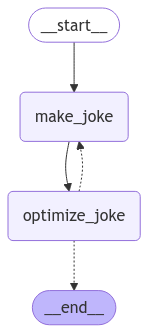

In [36]:
# State 
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str

class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )

# Augment the LLM
evaluator = llm.with_structured_output(Feedback)

def make_joke(state: State):
    if state.get('feedback'):
        msg=llm.invoke(f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}")
    else:
        msg=llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}

def optimize_joke(state: State):
    grade=evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}

def route_joke(state: State):
    if state['funny_or_not'] == "funny":
        return END 
    elif state['funny_or_not'] == "not funny":
        return "make_joke"

# Add the nodes
optimizer_builder = StateGraph(State)
optimizer_builder.add_node("make_joke", make_joke)
optimizer_builder.add_node("optimize_joke", optimize_joke)

# Build the chain
optimizer_builder.add_edge(START, "make_joke")
optimizer_builder.add_edge("make_joke", "optimize_joke")
optimizer_builder.add_conditional_edges("optimize_joke", route_joke, ["make_joke", END])
optimizer_workflow = optimizer_builder.compile()

# Show the chain 
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

In [37]:
state = optimizer_workflow.invoke({"topic": "Cats"})
print(state['joke'])

Why was the cat sitting on the computer?

Because it wanted to keep an eye on the mouse!


Trace: 

https://smith.langchain.com/public/8a2cad2e-1b4e-4643-bad1-6a71af33de17/r

## Agent 

Agents are typically just LLMs using tools based on environmental feedback in a loop. As noted in the [Anthropic blog post](https://www.anthropic.com/research/building-effective-agents): 

> Agents can handle sophisticated tasks, but their implementation is often straightforward. They are typically just LLMs using tools based on environmental feedback in a loop. It is therefore crucial to design toolsets and their documentation clearly and thoughtfully.

> When to use agents: Agents can be used for open-ended problems where it’s difficult or impossible to predict the required number of steps, and where you can’t hardcode a fixed path. The LLM will potentially operate for many turns, and you must have some level of trust in its decision-making. Agents' autonomy makes them ideal for scaling tasks in trusted environments.

#### Resources

**LangChain Academy**

See our lesson on agents here: 

https://github.com/langchain-ai/langchain-academy/blob/main/module-1/agent.ipynb

--- 

**Examples**

Here is a project that uses an agent to create long-term memories:

https://github.com/langchain-ai/memory-agent

In [38]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

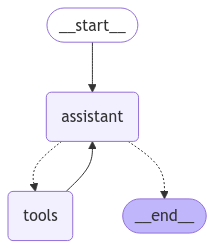

In [42]:
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langchain_core.messages import SystemMessage, HumanMessage

def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")] + state["messages"])]}

# Graph
agent_builder = StateGraph(MessagesState)
agent_builder.add_node("assistant", assistant)
agent_builder.add_node("tools", ToolNode(tools))
agent_builder.add_edge(START, "assistant")
agent_builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
agent_builder.add_edge("tools", "assistant")
agent = agent_builder.compile()

# Show
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [43]:
messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2. Divide the output by 5")]
messages = agent.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Multiply the output by 2. Divide the output by 5
================================== Ai Message ==================================
Tool Calls:
  add (call_c9AR2iqR2fTJitz8NpopdFIt)
 Call ID: call_c9AR2iqR2fTJitz8NpopdFIt
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  multiply (call_dgVIriPRmJRrIv0hqpl4OGOd)
 Call ID: call_dgVIriPRmJRrIv0hqpl4OGOd
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================
Tool Calls:
  divide (call_9wRM2D71BKrn22XPnk3K64S6)
 Call ID: call_9wRM2D71BKrn22XPnk3K64S6
  Args:
    a: 14
    b: 5
================================= Tool Message ===============

Trace: 

https://smith.langchain.com/public/246c20b8-304d-44be-82af-194eae0612a2/r

## Learning More

### Checkpoints and Human-in-the-Loop

See module 3 of LangChain Academy: 

https://github.com/langchain-ai/langchain-academy/tree/main/module-3

### Memory 

See modules 2 and 5 of LangChain Academy: 

https://github.com/langchain-ai/langchain-academy/tree/main/module-2

https://github.com/langchain-ai/langchain-academy/tree/main/module-5

### Deployment 

See module 6 of LangChain Academy: 

https://github.com/langchain-ai/langchain-academy/tree/main/module-6